In [62]:
import cv2
from matplotlib import pyplot
import numpy
from dataclasses import dataclass

# Ustawienie rozmarów wyświetlanych obrazów
pyplot.rcParams["figure.figsize"] = (18, 10)

In [63]:
#
# Wczytanie obrazów źródłowych
#
# źródło grafiki colors.jpg: https://unsplash.com/photos/gT5kuls6Y6Q
# źródło grafiki gacław-na-kuchni.jpg: własne
#
#image_from_file = cv2.imread('images/colors.jpg')
image_from_file = cv2.imread('images/gacław-na-kuchni.jpg')
image_gray = cv2.cvtColor(image_from_file, cv2.COLOR_BGR2GRAY)
image_color = cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB)
print('Rozmiar obrazka: ', image_from_file.shape)

Rozmiar obrazka:  (768, 1024, 3)


# Zadanie 1

In [64]:
output = numpy.copy(image_gray)
output = output.astype(dtype=int)

#
# Algorytm
#
def find_closest_palette_color(value):
    return round(value / 255) * 255

for y in range(output.shape[0] - 1):
    for x in range(output.shape[1] - 1):
        oldpixel = output[y][x]
        newpixel = find_closest_palette_color(oldpixel)
        output[y][x] = newpixel
        quant_error = oldpixel - newpixel
        output[y][x + 1] = output[y][x + 1] + quant_error * 7 / 16
        output[y + 1][x - 1] = output[y + 1][x - 1] + quant_error * 3 / 16
        output[y + 1][x] = output[y + 1][x] + quant_error * 5 / 16
        output[y + 1][x + 1] = output[y + 1][x + 1] + quant_error * 1 / 16

numpy.clip(output, 0, 255)
output = output.astype(dtype=numpy.uint8)

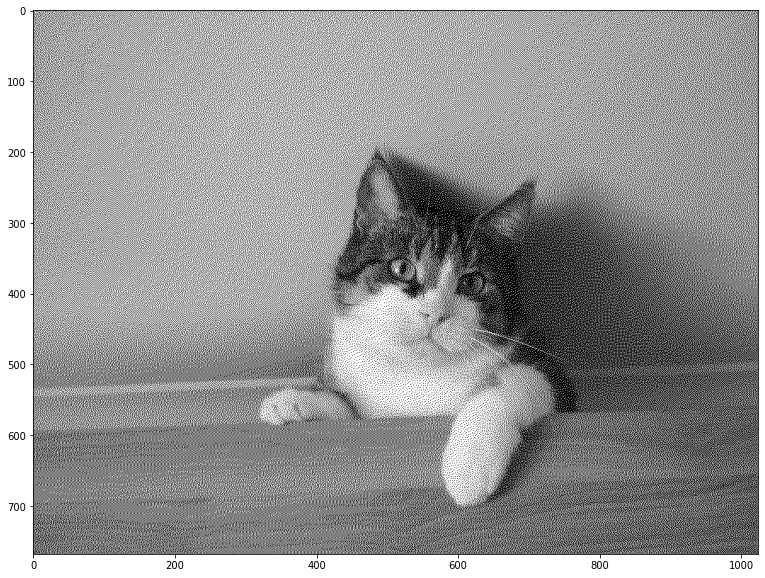

In [65]:
#
# Wyświetlenie
#
pyplot.imshow(output, cmap='gray')

Text(0, 0.5, 'Liczba pikseli obrazu []')

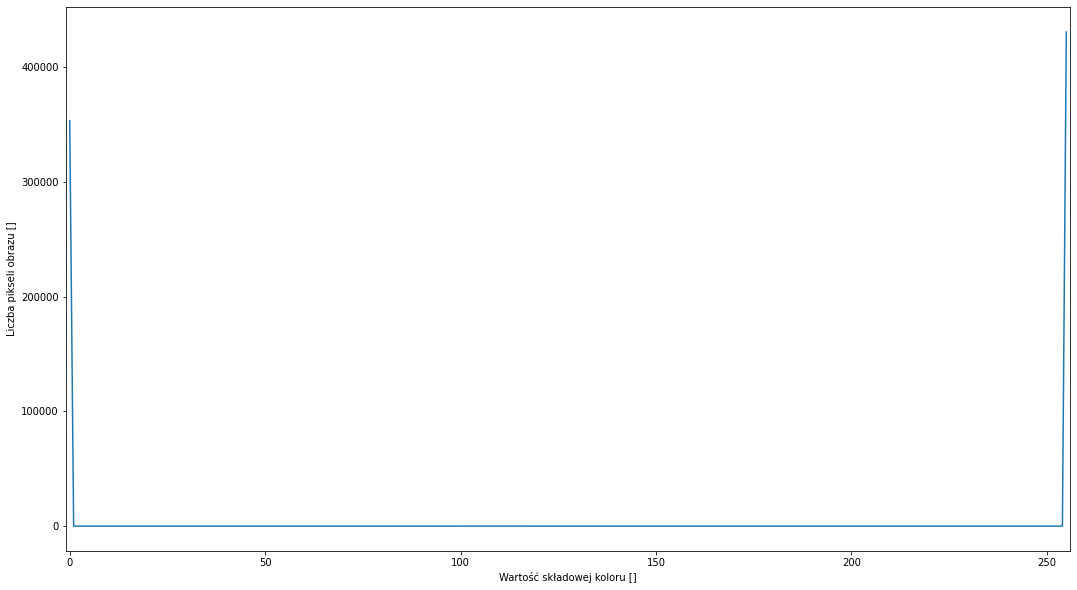

In [66]:
#
# Histogram
#
histr = cv2.calcHist([output], [0], None, [256], [0, 256])
pyplot.plot(histr)
pyplot.xlim([-1, 256])
pyplot.xlabel('Wartość składowej koloru []')
pyplot.ylabel('Liczba pikseli obrazu []')

# Zadanie 2

In [67]:
output = numpy.copy(image_color)
output = output.astype(dtype=int)

#
# Algorytm
#
def find_closest_palette_color(value, k):
    return round((k - 1) * value / 255) * 255 / (k - 1)

for y in range(output.shape[0] - 1):
    for x in range(output.shape[1] - 1):
        oldpixel = output[y][x]
        for i in range(3):
            newpixel = find_closest_palette_color(oldpixel[i], 8)
            output[y][x][i] = newpixel
            quant_error = oldpixel[i] - newpixel
            output[y][x + 1][i] = output[y][x + 1][i] + quant_error * 7 / 16
            output[y + 1][x - 1][i] = output[y + 1][x - 1][i] + quant_error * 3 / 16
            output[y + 1][x][i] = output[y + 1][x][i] + quant_error * 5 / 16
            output[y + 1][x + 1][i] = output[y + 1][x + 1][i] + quant_error * 1 / 16

numpy.clip(output, 0, 255)
output = output.astype(dtype=numpy.uint8)

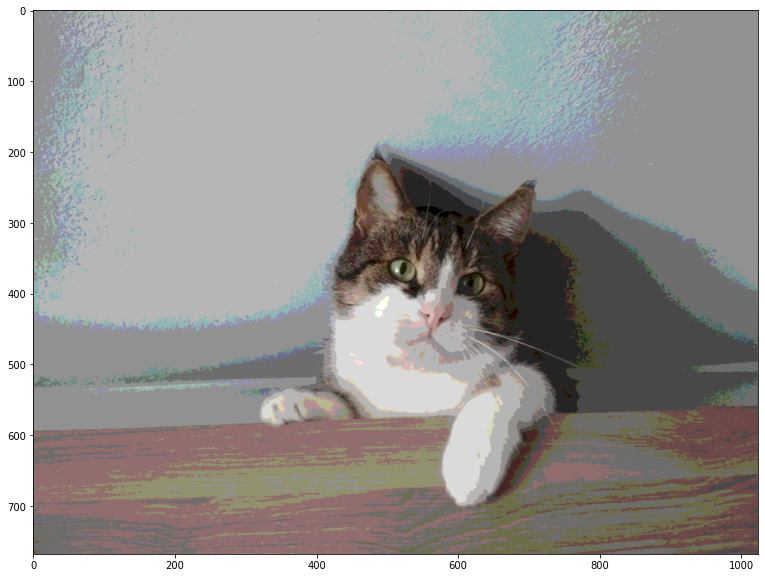

In [68]:
#
# Wyświetlenie
#
pyplot.imshow(output)

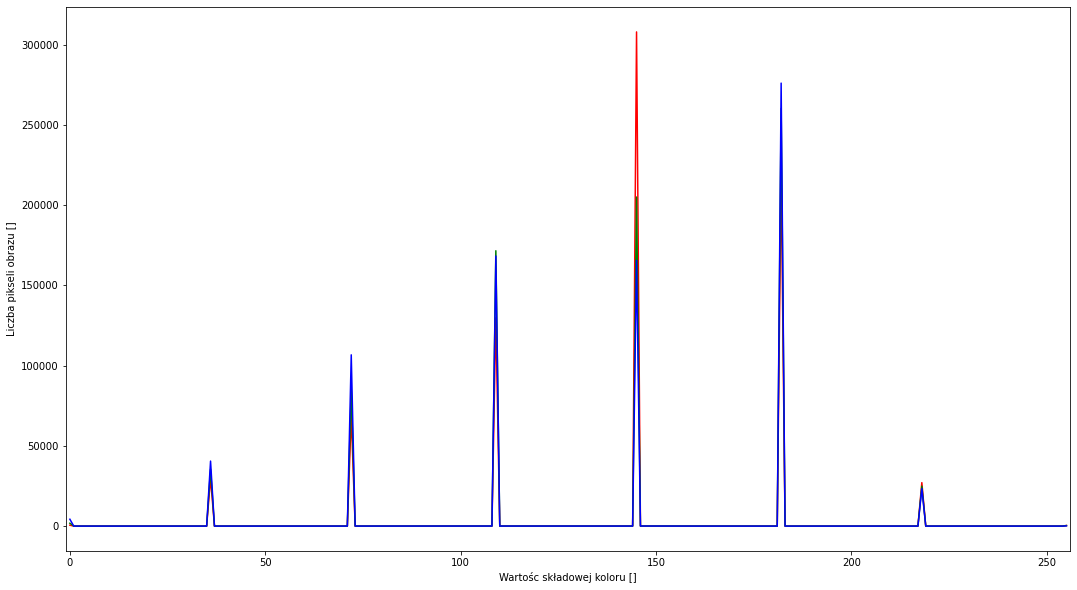

In [69]:
#
# Histogram
#
color = ('r', 'g', 'b')

for i, col in enumerate(color):
    histr = cv2.calcHist([output], [i], None, [256], [0, 256])
    pyplot.plot(histr, color=col)
    pyplot.xlim([-1, 256])
    pyplot.xlabel('Wartośc składowej koloru []')
    pyplot.ylabel('Liczba pikseli obrazu []')

# Zadanie 3

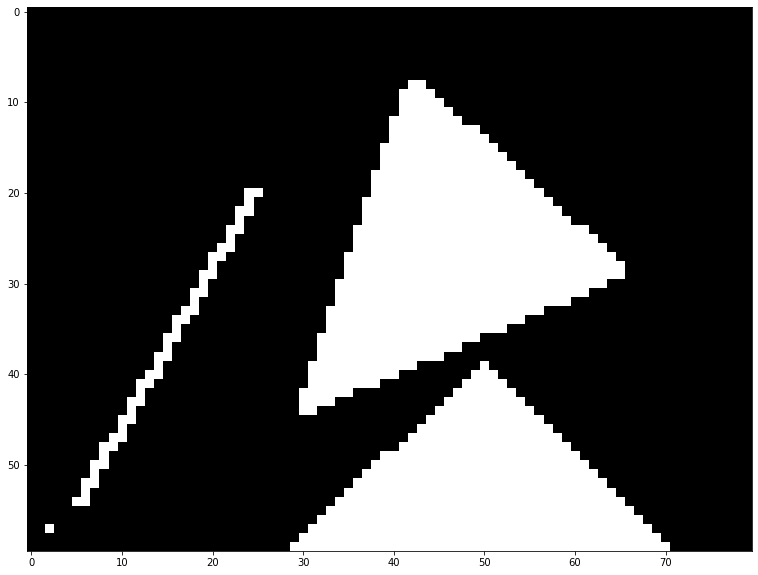

In [70]:
#
# Przygotowanie płótna
#
width = 80
height = 60
image = numpy.zeros((height, width, 3), dtype=numpy.uint8)

@dataclass
class Point:
    x: int
    y: int

#
# Funkcja rysująca punkt
#
# NOTE(sdatko): punkt 0,0 to lewy dolny róg obrazu
#
def draw_point(image, x, y, color=(255, 255, 255)):
    image[image.shape[0] - 1 - y, x, :] = color


#
# Funkcja rysująca linię
#
def draw_line(image, x1, y1, x2, y2):
    delta_X = abs(x2 - x1)
    delta_Y = abs(y2 - y1)
    x_i = numpy.sign(x2 - x1)
    y_i = numpy.sign(y2 - y1)
    
    if delta_X > delta_Y:
        d = 2 * delta_Y - delta_X
    else:
        d = 2 * delta_X - delta_Y
        
    x = x1
    y = y1
    while x != x2 or y != y2:  
        draw_point(image, x, y)
        
        if d < 0:
            if delta_X > delta_Y:
                x += x_i
                d += 2 * delta_Y
            else:
                y += y_i
                d += 2 * delta_X
        else:
            if delta_X > delta_Y:
                y += y_i
                d -= 2 * delta_X
            else:
                x += x_i
                d -= 2 * delta_Y
#
# Funkcja rysująca trójkąt
#
def calc_area(a, b, c):
    return (c.x - a.x) * (b.y - a.y) - (c.y - a.y) * (b.x - a.x)

def draw_triangle(image, a, b, c):
    draw_line(image, a.x, a.y, b.x, b.y)
    draw_line(image, b.x, b.y, c.x, c.y)
    draw_line(image, c.x, c.y, a.x, a.y)
    x_min = min(a.x, b.x, c.x)
    x_max = max(a.x, b.x, c.x)
    y_min = min(a.y, b.y, c.y)
    y_max = max(a.y, b.y, c.y)
    for x_i in range(x_min, x_max):
        for y_i in range(y_min, y_max):
            p = Point(x_i, y_i)
            lambda_0 = calc_area(a, b, p)
            lambda_1 = calc_area(b, c, p)
            lambda_2 = calc_area(c, a, p)
            if (lambda_0 ^ lambda_1) >= 0 and (lambda_1 ^ lambda_2) >= 0:
                draw_point(image, p.x, p.y)

#
# Rysowanie
#
draw_point(image, 2, 2)
draw_line(image, 5, 5, 25, 40)
a = Point(30, 15)
b = Point(65, 30)
c = Point(42, 51)
draw_triangle(image, a, b, c)
a = Point(29, 0)
b = Point(70, 0)
c = Point(50, 20)
draw_triangle(image, a, b, c)
    
#
# Wyświetlenie
#
pyplot.imshow(image)

# Zadanie 4

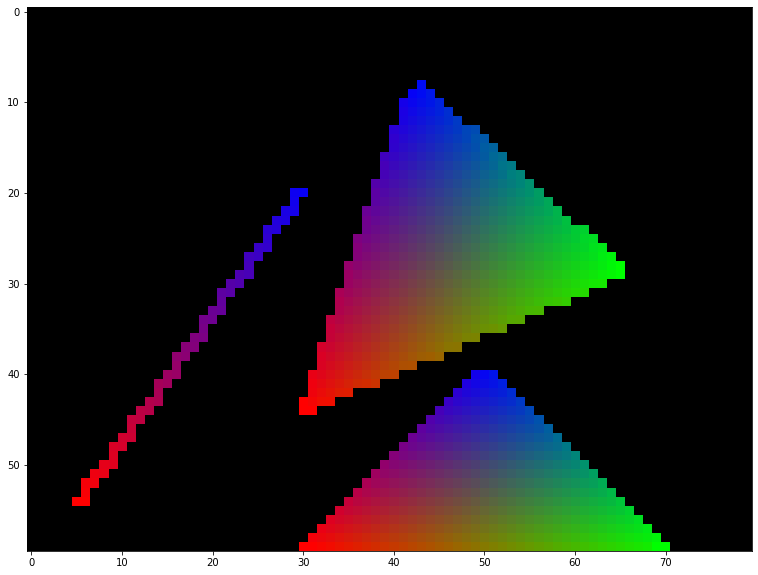

In [47]:
#
# Przygotowanie płótna
#
width = 80
height = 60
image = numpy.zeros((height, width, 3), dtype=numpy.uint8)


@dataclass
class Point:
    x: int
    y: int
    color: tuple = (255, 255, 255)

#
# Funkcja rysująca punkt
#
# NOTE(sdatko): punkt 0,0 to lewy dolny róg obrazu
#
def draw_point(image, x, y, color=(255, 255, 255)):
    image[image.shape[0] - 1 - y, x, :] = color


#
# Funkcja rysująca linię
#
def draw_line(image, x1, y1, x2, y2, start_color=(255, 0, 0), end_color=(0, 0, 255)):
    delta_X = abs(x2 - x1)
    delta_Y = abs(y2 - y1)
    x_i = numpy.sign(x2 - x1)
    y_i = numpy.sign(y2 - y1)
    
    if delta_X > delta_Y:
        d = 2 * delta_Y - delta_X
    else:
        d = 2 * delta_X - delta_Y
        
    x = x1
    y = y1
    color = start_color
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
    
    while x != x2 or y != y2:  
        draw_point(image, x, y, color)
        t = ((x - x1) ** 2 + (y - y1) ** 2) ** 0.5 / distance
        color = numpy.add(start_color, t * numpy.subtract(end_color, start_color))
        if d < 0:
            if delta_X > delta_Y:
                x += x_i
                d += 2 * delta_Y
            else:
                y += y_i
                d += 2 * delta_X
        else:
            if delta_X > delta_Y:
                y += y_i
                d -= 2 * delta_X
            else:
                x += x_i
                d -= 2 * delta_Y


#
# Funkcja rysująca trójkąt
#
def calc_area(a, b, c):
    return (c.x - a.x) * (b.y - a.y) - (c.y - a.y) * (b.x - a.x)

def draw_triangle(image, a, b, c):
    draw_line(image, a.x, a.y, b.x, b.y, a.color, b.color)
    draw_line(image, a.x, a.y, c.x, c.y, a.color, c.color)
    draw_line(image, b.x, b.y, c.x, c.y, b.color, c.color)
    x_min = min(a.x, b.x, c.x)
    x_max = max(a.x, b.x, c.x)
    y_min = min(a.y, b.y, c.y)
    y_max = max(a.y, b.y, c.y)
    lambda_all = calc_area(a, b, c)
    for x_i in range(x_min, x_max):
        for y_i in range(y_min, y_max):
            p = Point(x_i, y_i)
            lambda_0 = calc_area(a, b, p)
            lambda_1 = calc_area(b, c, p)
            lambda_2 = calc_area(c, a, p)
            l0 = lambda_0 / lambda_all
            l1 = lambda_1 / lambda_all
            l2 = lambda_2 / lambda_all
            p.color = numpy.multiply(l0, c.color) + numpy.multiply(l1, a.color) + numpy.multiply(l2, b.color)
            if (lambda_0 ^ lambda_1) >= 0 and (lambda_1 ^ lambda_2) >= 0:
                draw_point(image, p.x, p.y, p.color)


#
# Rysowanie
#
draw_line(image, 5, 5, 30, 40)
a = Point(30, 15, (255, 0, 0))
b = Point(65, 30, (0, 255, 0))
c = Point(42, 51, (0, 0, 255))
draw_triangle(image, a, b, c)
a = Point(30, 0, (255, 0, 0))
b = Point(70, 0, (0, 255, 0))
c = Point(50, 20, (0, 0, 255))
draw_triangle(image, a, b, c)

#
# Wyświetlenie
#
pyplot.imshow(image)

# Zadanie 5

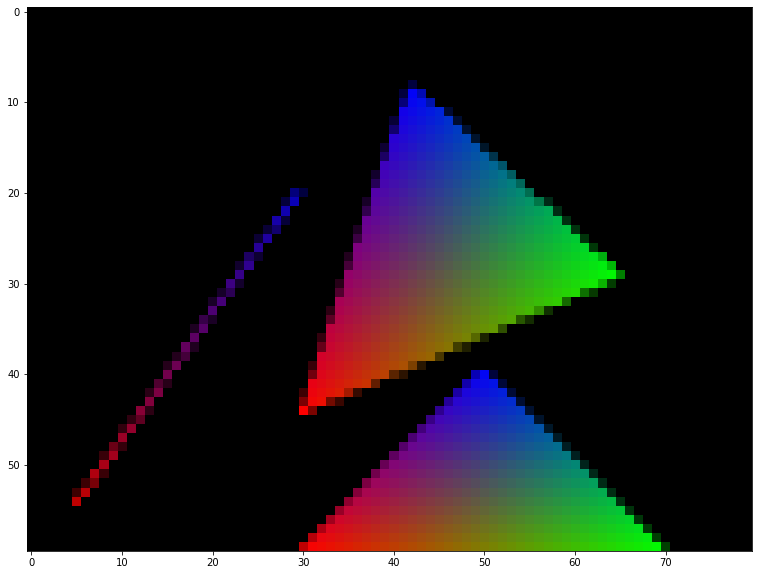

In [60]:
#
# Przygotowanie płótna
#
scale = 2

width = 80
height = 60
image = numpy.zeros((height, width, 3), dtype=numpy.uint8)
image_scaled = numpy.zeros(
    (height * scale, width * scale, 3), dtype=numpy.uint8)


@dataclass
class Point:
    x: int
    y: int
    color: tuple = (255, 255, 255)

#
# Funkcja rysująca punkt
#
# NOTE(sdatko): punkt 0,0 to lewy dolny róg obrazu
#


def draw_point(image, x, y, color=(255, 255, 255)):
    image[image.shape[0] - 1 - y, x, :] = color


#
# Funkcja rysująca linię
#
def draw_line(image, x1, y1, x2, y2, start_color=(255, 0, 0), end_color=(0, 0, 255)):
    delta_X = abs(x2 - x1)
    delta_Y = abs(y2 - y1)
    x_i = numpy.sign(x2 - x1)
    y_i = numpy.sign(y2 - y1)

    if delta_X > delta_Y:
        d = 2 * delta_Y - delta_X
    else:
        d = 2 * delta_X - delta_Y

    x = x1
    y = y1
    color = start_color
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    while x != x2 or y != y2:
        draw_point(image, x, y, color)
        t = ((x - x1) ** 2 + (y - y1) ** 2) ** 0.5 / distance
        color = numpy.add(
            start_color, t * numpy.subtract(end_color, start_color))
        if d < 0:
            if delta_X > delta_Y:
                x += x_i
                d += 2 * delta_Y
            else:
                y += y_i
                d += 2 * delta_X
        else:
            if delta_X > delta_Y:
                y += y_i
                d -= 2 * delta_X
            else:
                x += x_i
                d -= 2 * delta_Y


#
# Funkcja rysująca trójkąt
#
def calc_area(a, b, c):
    return (c.x - a.x) * (b.y - a.y) - (c.y - a.y) * (b.x - a.x)


def draw_triangle(image, a, b, c):
    draw_line(image, a.x, a.y, b.x, b.y, a.color, b.color)
    draw_line(image, a.x, a.y, c.x, c.y, a.color, c.color)
    draw_line(image, b.x, b.y, c.x, c.y, b.color, c.color)
    x_min = min(a.x, b.x, c.x)
    x_max = max(a.x, b.x, c.x)
    y_min = min(a.y, b.y, c.y)
    y_max = max(a.y, b.y, c.y)
    lambda_all = calc_area(a, b, c)
    for x_i in range(x_min, x_max):
        for y_i in range(y_min, y_max):
            p = Point(x_i, y_i)
            lambda_0 = calc_area(a, b, p)
            lambda_1 = calc_area(b, c, p)
            lambda_2 = calc_area(c, a, p)
            l0 = lambda_0 / lambda_all
            l1 = lambda_1 / lambda_all
            l2 = lambda_2 / lambda_all
            p.color = numpy.multiply(
                l0, c.color) + numpy.multiply(l1, a.color) + numpy.multiply(l2, b.color)
            if (lambda_0 ^ lambda_1) >= 0 and (lambda_1 ^ lambda_2) >= 0:
                draw_point(image, p.x, p.y, p.color)

#
# Antyaliasing
#


def ssaa(image, image_scaled):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            image[y, x, 0] = numpy.average(
                image_scaled[y*scale:y*scale+2, x*scale:x*scale+2, 0])
            image[y, x, 1] = numpy.average(
                image_scaled[y*scale:y*scale+2, x*scale:x*scale+2, 1])
            image[y, x, 2] = numpy.average(
                image_scaled[y*scale:y*scale+2, x*scale:x*scale+2, 2])


#
# Rysowanie
#
draw_line(image_scaled, 5 * scale, 5 * scale, 30 * scale, 40 * scale)
a = Point(30 * scale, 15 * scale, (255, 0, 0))
b = Point(65 * scale, 30 * scale, (0, 255, 0))
c = Point(42 * scale, 51 * scale, (0, 0, 255))
draw_triangle(image_scaled, a, b, c)
a = Point(30 * scale, 0 * scale, (255, 0, 0))
b = Point(70 * scale, 0 * scale, (0, 255, 0))
c = Point(50 * scale, 20 * scale, (0, 0, 255))
draw_triangle(image_scaled, a, b, c)
ssaa(image, image_scaled)

#
# Wyświetlenie
#
pyplot.imshow(image)
